In [1]:
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 110
import numpy as np
import gc
import seaborn as sns
#from dask.distributed import Client,wait,LocalCluster

In [2]:
%%time

columns=[
    "raw_feature_tweet_id",
    "raw_feature_tweet_timestamp",
    "raw_feature_engagement_reply_timestamp",
    "raw_feature_engagement_retweet_timestamp",
    "raw_feature_engagement_comment_timestamp",
    "raw_feature_engagement_like_timestamp"
]

df = dd.read_parquet('G:\RecSysChallenge2021\sample.parquet', engine='pyarrow', columns=columns).compute()

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78599968 entries, 24664 to 26358
Data columns (total 6 columns):
 #   Column                                    Dtype 
---  ------                                    ----- 
 0   raw_feature_tweet_id                      object
 1   raw_feature_tweet_timestamp               Int32 
 2   raw_feature_engagement_reply_timestamp    Int32 
 3   raw_feature_engagement_retweet_timestamp  Int32 
 4   raw_feature_engagement_comment_timestamp  Int32 
 5   raw_feature_engagement_like_timestamp     Int32 
dtypes: Int32(5), object(1)
memory usage: 3.0+ GB
Wall time: 5min 38s


In [3]:
%%time

df["mapped_feature_tweet_id"] = df["raw_feature_tweet_id"].astype('category').cat.codes
df = df.drop('raw_feature_tweet_id', axis = 1)

gc.collect()

df.head()

Wall time: 8min 24s


,raw_feature_tweet_timestamp,raw_feature_engagement_reply_timestamp,raw_feature_engagement_retweet_timestamp,raw_feature_engagement_comment_timestamp,raw_feature_engagement_like_timestamp,mapped_feature_tweet_id
24664,1613503486,<NA>,<NA>,<NA>,1613523519,37515430
89447,1613503794,<NA>,<NA>,<NA>,<NA>,4460350
87332,1612573525,<NA>,1612576915,<NA>,1612576915,42494194
22500,1613114858,<NA>,<NA>,<NA>,1613120192,16993919
82911,1613613548,<NA>,<NA>,<NA>,1613683669,8076949


In [4]:
%%time

engagement_types=["reply","retweet","comment","like"]
type_dfs=[]

for _type in engagement_types:
    
    columns=[
        "raw_feature_tweet_timestamp",
        "raw_feature_engagement_{}_timestamp".format(_type)
    ]
    
    temp=df[df[columns[1]].notnull()]
    temp=temp[columns]
    temp['time_delta_hours']=(temp[columns[1]]-temp[columns[0]])/(60*60)
    temp['engagement_type']=_type
    temp=temp.drop(columns, axis=1)
    
    type_dfs.append(temp)
    

del temp
gc.collect()

timedelta_df=pd.concat(type_dfs).reset_index(drop=True)

timedelta_df.head()

Wall time: 18.3 s


,time_delta_hours,engagement_type
0,0.034444,reply
1,2.891111,reply
2,0.012500,reply
3,0.008889,reply
4,8.162500,reply


## Common sense would suggest that the majority of the engagements happens right after creation, is it true?

(0.0, 24.0)

<Figure size 660x440 with 0 Axes>

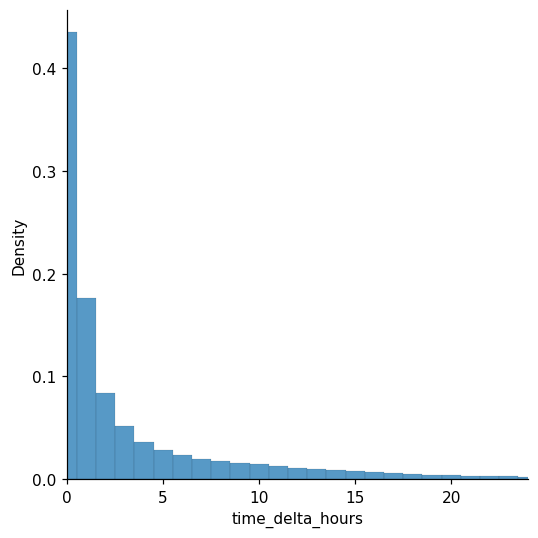

In [8]:
plt.clf()

sns.displot(timedelta_df, x="time_delta_hours", stat="density", discrete=True)

plt.xlim(0, 24)

## Does this pattern change with the engagement type?

(0.0, 24.0)

<Figure size 660x440 with 0 Axes>

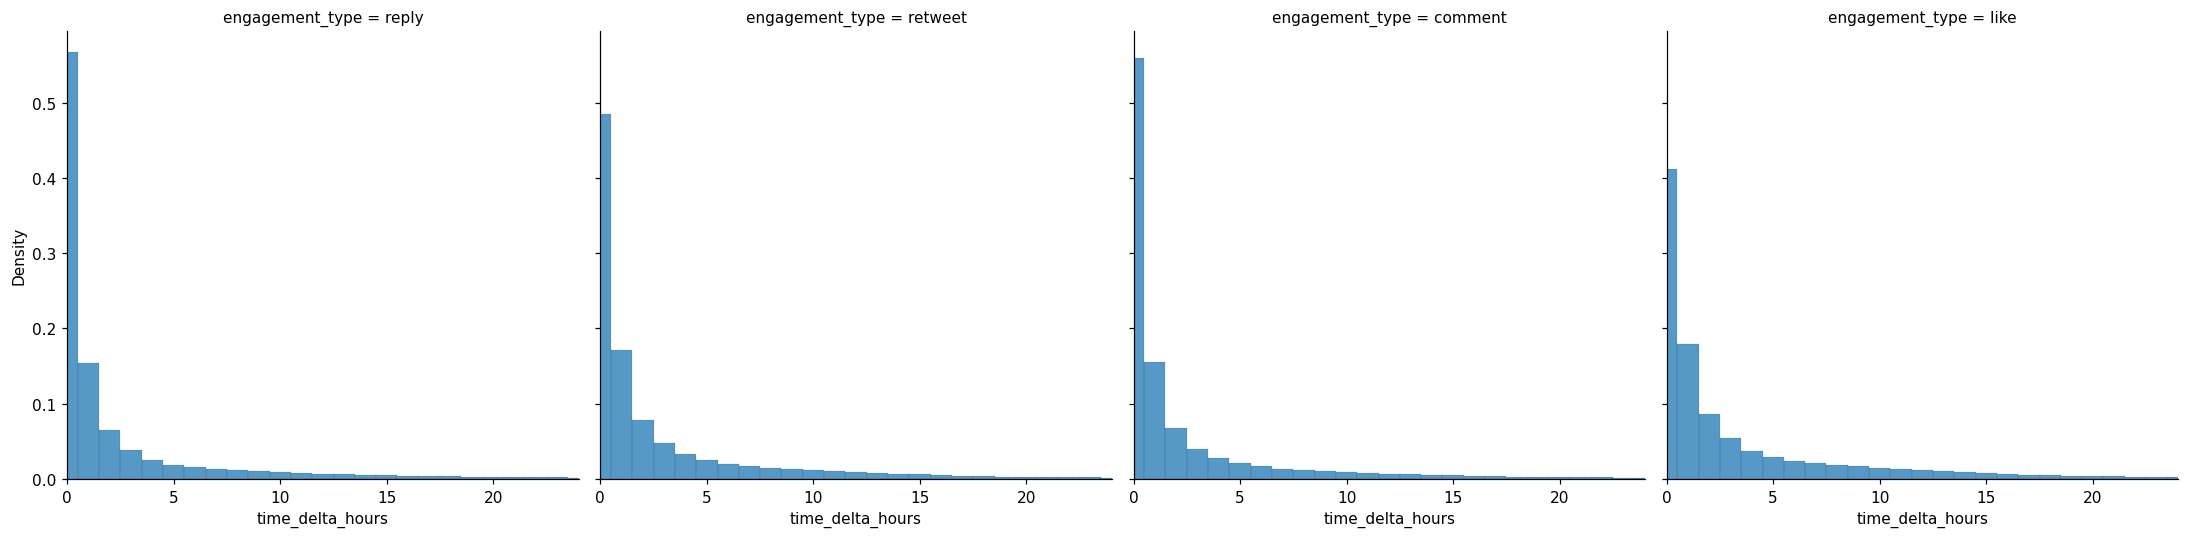

In [9]:
plt.clf()

sns.displot(timedelta_df, x="time_delta_hours", stat="density", col="engagement_type",discrete=True, common_norm=False, multiple="dodge")

plt.xlim(0, 24)

## Kinda, let's make it clearer:

(0.0, 24.0)

<Figure size 660x440 with 0 Axes>

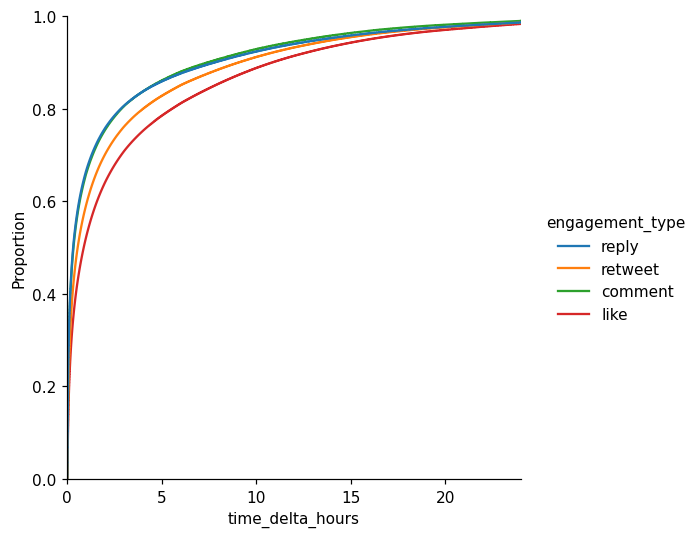

In [10]:
plt.clf()

sns.displot(timedelta_df, x="time_delta_hours", hue="engagement_type", kind="ecdf")

plt.xlim(0, 24)